In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Define fitting functions
def expf(t, V0, A, tau):
    return V0 + A * np.exp(-(t)/tau)
def linf(x, m, q):
    return m * x + q

pd.set_option('display.float_format', lambda x: '%.7E' % x)
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# La funzione chiq prende come parametri i valori teorici, le osservazioni, e gli errori sulle osservazioni
def chiq(exp, obs, obsErr):
    return sum(np.power((exp - obs), 2) / np.power(obsErr, 2))

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# La funzione testchiq prende come parametri i gradi di libertà, quantile inf, quantile sup e valore del chi quadro
def testchiq(degf, infq, supq, valchiq):
    infchiq = chi2.isf(
        q=1 - infq, df=degf)
    supchiq = chi2.isf(
        q=1 - supq, df=degf)
    print('Chi quadrato per modello e osservazioni: %f.' % valchiq)
    print(
        'Studiamo se il chi quadro è nel range [%f, %f]' % (infchiq, supchiq))
    if (valchiq <= supchiq) & (valchiq >= infchiq):
        print(color.BOLD + color.GREEN + 'Test del chi quadro superato!' +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Test del chi quadro non superato!' +
              color.END + color.END)


# La funzione stattest prende come parametri valore 1, errore 1, valore 2, errore 2, e infine il fattore di copertura.
def stattest(val1, val2, err1, err2, kcop):
    R = abs(val1 - val2)
    errR = sqrt(err1**2 + err2**2)
    infconf = R - kcop * errR
    supconf = R + kcop * errR
    if (0 > infconf) & (0 < supconf):
        print(color.BOLD + color.GREEN +
              'Il test è superato con una confidenza di %.0f sigma!' % (kcop) +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED +
              'Il test non è superato con un confidenza di %.0f sigma' %
              (kcop) + color.END + color.END)

In [3]:
R1 = 9.8950e3
R2 = 47.130
C0 = 9.897e-9
L0 = 100e-3

'popt1'

-1.013101445416812

0.15121917084024636

0.00013820870997624388

0             1             2             3
0 9.8380486E-05 9.8703459E-05 9.8907039E-05 9.8596666E-05
1 1.0831341E-04 1.0849128E-04 1.0836714E-04 1.0888023E-04
2 1.1825747E-04 1.1812153E-04 1.1799473E-04 1.1790974E-04
3 1.2835281E-04 1.2832337E-04 1.2841037E-04 1.2852816E-04
4 1.3816328E-04 1.3843110E-04 1.3842630E-04 1.3820871E-04

length          mean           std      capacity   capacityerr
0       0 9.8646913E-05 2.1937137E-07 9.9693696E-09 2.2192325E-11
1      10 1.0851302E-04 2.5588914E-07 1.0966449E-08 2.5883691E-11
2      20 1.1807087E-04 1.5182021E-07 1.1932377E-08 1.5389454E-11
3      30 1.2840368E-04 9.0513556E-08 1.2976622E-08 9.2389889E-12
4      40 1.3830735E-04 1.4136218E-07 1.3977498E-08 1.4354437E-11

0   9.8646913E-05
1   1.0851302E-04
2   1.1807087E-04
3   1.2840368E-04
4   1.3830735E-04
Name: mean, dtype: float64

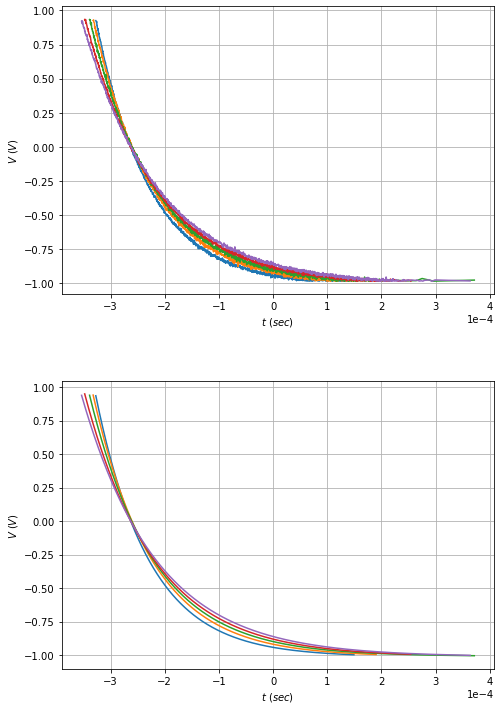

In [4]:
# Capacitive measurements
tau1 = []
fig1 = plt.figure()
ax1_1 = fig1.add_axes([0, 1.3, 1, 1], label='captures')
ax1_2 = fig1.add_axes([0, 0, 1, 1], label='fit')
ax1_1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1_1.grid()
ax1_1.set_xlabel('$t$ ($sec$)')
ax1_1.set_ylabel('$V$ ($V$)')
ax1_2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1_2.grid()
ax1_2.set_xlabel('$t$ ($sec$)')
ax1_2.set_ylabel('$V$ ($V$)')
for i in range(0, 5):
    settings_file = f'data/c{i}_1.txt'
    tOscScaleC = 82e-6
    delta_V = 8*270e-3*3e-2
    for j in range(1, 5):
        file_name = f'data/c{i}_{j}.csv'
        df = pd.read_csv(file_name, skiprows=[0]).dropna()
        df = df[(df['Volt'] < 1-delta_V) & (df['Volt'] >= -1+.2*delta_V)]
        df['second'] = df['second'].map(lambda x: x-0.00026154604205792017)
        p0 = [0, 1, 1e-5]
        popt1, pcov1 = curve_fit(expf, df['second'], df['Volt'], p0=p0)
        tau1.append(popt1[2])
    ax1_1.plot(df.second, df.Volt)
    ax1_2.plot(df.second, expf(df.second, *popt1))
display('popt1', *popt1)
tau1 = np.reshape(tau1, (5,4))
tau1data = pd.DataFrame(data=tau1[:,:],
                     index=range(0,5),
                     columns=range(0,4))
tau1dict = {
    'length': range(0,50,10),
    'mean': tau1data.mean(axis=1),
    'std': tau1data.std(axis=1),
    'capacity': tau1data.mean(axis=1).map(lambda x: x/R1),
    'capacityerr': (np.sqrt(np.power(tau1data.std(axis=1)/tau1data.mean(axis=1), 2) + np.power((0.0001*R1)/R1, 2))*tau1data.mean(axis=1).map(lambda x: x/R1))
}
tau1df = pd.DataFrame(tau1dict)
display(tau1data)
display(tau1df)
display(tau1df['mean'])
popt2, pcov2 = curve_fit(linf, tau1df['length'], tau1df['capacity'])

1.0026430638944884e-10

9.959177150210676e-09

array([6.59664998e-13, 1.61584264e-11])

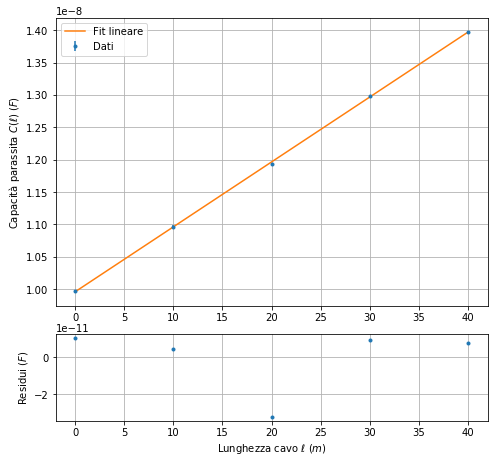

In [5]:
fig2 = plt.figure()
ax2_1 = fig2.add_axes([0,.4,1,1], label='plots')
ax2_2 = fig2.add_axes([0,0,1,.3], label='residuals')
ax2_1.grid()
ax2_1.errorbar(tau1df['length'], tau1df['capacity'], yerr=tau1df['capacityerr'], ls='None', marker='.', label='Dati')
ax2_1.plot(tau1df['length'], linf(tau1df['length'], *popt2), label='Fit lineare')
ax2_1.set_ylabel('Capacità parassita $C(\ell)$ ($F$)')
ax2_1.legend(loc='best')
ax2_2.grid()
ax2_2.plot(tau1df['length'], tau1df['capacity'] - linf(tau1df['length'], *popt2), '.')
ax2_2.set_xlabel('Lunghezza cavo $\ell$ ($m$)')
ax2_2.set_ylabel('Residui ($F$)')
display(*popt2, np.sqrt(np.diag(pcov2)))

In [6]:
chiq1 = chiq(linf(tau1df['length'], *popt2), tau1df['capacity'], tau1df['capacityerr'])
testchiq(4, .005, .995, chiq1)

Chi quadrato per modello e osservazioni: 5.942349.
Studiamo se il chi quadro è nel range [0.206989, 14.860259]
Test del chi quadro superato!


In [7]:
print(tau1df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  length &          mean &           std &      capacity &   capacityerr \\
\midrule
0 &       0 & 9.8646913E-05 & 2.1937137E-07 & 9.9693696E-09 & 2.2192325E-11 \\
1 &      10 & 1.0851302E-04 & 2.5588914E-07 & 1.0966449E-08 & 2.5883691E-11 \\
2 &      20 & 1.1807087E-04 & 1.5182021E-07 & 1.1932377E-08 & 1.5389454E-11 \\
3 &      30 & 1.2840368E-04 & 9.0513556E-08 & 1.2976622E-08 & 9.2389889E-12 \\
4 &      40 & 1.3830735E-04 & 1.4136218E-07 & 1.3977498E-08 & 1.4354437E-11 \\
\bottomrule
\end{tabular}



array([-4.68434502e-01,  7.36012144e-01,  1.10823610e-06])

array([[ 1.41870924e-02, -1.19903612e-02, -5.34381864e-08],
       [-1.19903612e-02,  1.77444076e-02,  3.47679268e-08],
       [-5.34381864e-08,  3.47679268e-08,  2.55602839e-13]])

0             1             2             3             4
0 1.0133561E-06 1.0155681E-06 1.0130143E-06 1.0183691E-06 1.0133305E-06
1 1.0382494E-06 1.0385052E-06 1.0367104E-06 1.0410666E-06 1.0404741E-06
2 1.0594207E-06 1.0602792E-06 1.0622632E-06 1.0608829E-06 1.0610684E-06
3 1.0836958E-06 1.0876876E-06 1.0815938E-06 1.0841815E-06 1.0824593E-06
4 1.1122354E-06 1.1149673E-06 1.1083031E-06 1.1153545E-06 1.1082361E-06

length          mean           std    inductance  inductanceerr
0       0 1.0147276E-06 2.2767907E-09 9.8560493E-05  2.2189407E-07
1      10 1.0390011E-06 1.7673617E-09 1.0091818E-04  1.7267471E-07
2      20 1.0607829E-06 1.0478787E-09 1.0303384E-04  1.0354753E-07
3      30 1.0839236E-06 2.3376399E-09 1.0528150E-04  2.2788767E-07
4      40 1.1118193E-06 3.4562786E-09 1.0799101E-04  3.3630146E-07

0   1.0147276E-06
1   1.0390011E-06
2   1.0607829E-06
3   1.0839236E-06
4   1.1118193E-06
Name: mean, dtype: float64

2.3224345967477257e-07

9.851213489450306e-05

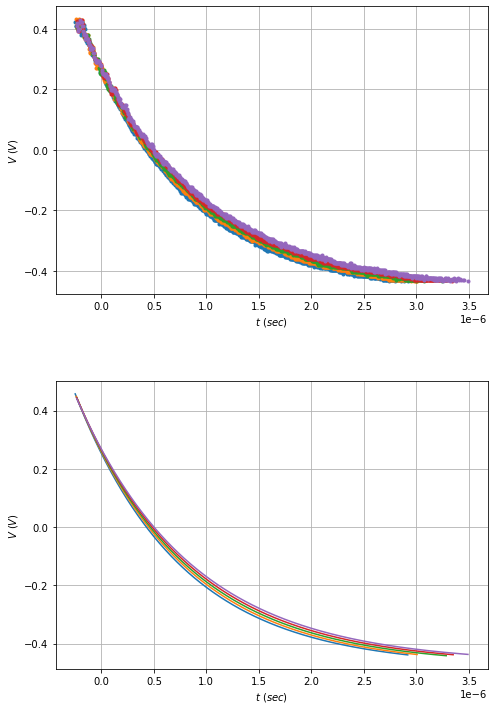

In [8]:
# Inductive measurements
tau2 = []
fig3 = plt.figure()
ax3_1 = fig3.add_axes([0,1.3,1,1], label='captures')
ax3_2 = fig3.add_axes([0,0,1,1], label='fit')
ax3_1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3_1.grid()
ax3_1.set_xlabel('$t$ ($sec$)')
ax3_1.set_ylabel('$V$ ($V$)')
ax3_2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3_2.grid()
ax3_2.set_xlabel('$t$ ($sec$)')
ax3_2.set_ylabel('$V$ ($V$)')
for i in range(0, 5):
    settings_file = f'data/l{i}_1.txt'
    #tOscScaleC = 82e-6
    delta_V = 8*270e-3*3e-2
    for j in range(1, 6):
        file_name = f'data/l{i}_{j}.csv'
        df3 = pd.read_csv(file_name, skiprows=[0]).dropna()
        df3 = df3[(df3['Volt'] < .5-delta_V) & (df3['Volt'] >= -.5+1*delta_V)]
        df3['second'] = df3['second'].map(lambda x: x-2.85990919e-04)
        p0_3 = [-.5, .5, 1e-5]
        popt3, pcov3 = curve_fit(expf, df3['second'], df3['Volt'], p0=p0_3, maxfev=15000, absolute_sigma=True)
        tau2.append(popt3[2])
    ax3_1.plot(df3.second, df3.Volt, '.')
    ax3_2.plot(df3.second, expf(df3.second, *popt3))
display(popt3, pcov3)
tau2 = np.reshape(tau2, (5,5))
tau2data = pd.DataFrame(data=tau2[:,:],
                     index=range(0,5),
                     columns=range(0,5))
tau2dict = {
    'length': range(0,50,10),
    'mean': tau2data.mean(axis=1),
    'std': tau2data.std(axis=1),
    'inductance': tau2data.mean(axis=1).map(lambda x: x*(R2+50)),
    'inductanceerr': np.sqrt(np.power(tau2data.std(axis=1)/tau2data.mean(axis=1),2) + np.power((R2*0.0001+0.004)/R2,2))*tau2data.mean(axis=1).map(lambda x: x*(R2+50))
}
tau2df = pd.DataFrame(tau2dict)
display(tau2data)
display(tau2df)
display(tau2df['mean'])
popt4, pcov4 = curve_fit(linf, tau2df['length'], tau2df['inductance'])
display(*popt4)

In [9]:
display(popt1, np.sqrt(np.diag(pcov1)))
display(popt3, np.sqrt(np.diag(pcov3)))

array([-1.01310145e+00,  1.51219171e-01,  1.38208710e-04])

array([3.95978256e-04, 3.27155478e-04, 1.21555010e-07])

array([-4.68434502e-01,  7.36012144e-01,  1.10823610e-06])

array([1.19109582e-01, 1.33208136e-01, 5.05571794e-07])

2.3224345967477257e-07

9.851213489450306e-05

array([5.75755939e-09, 1.41030828e-07])

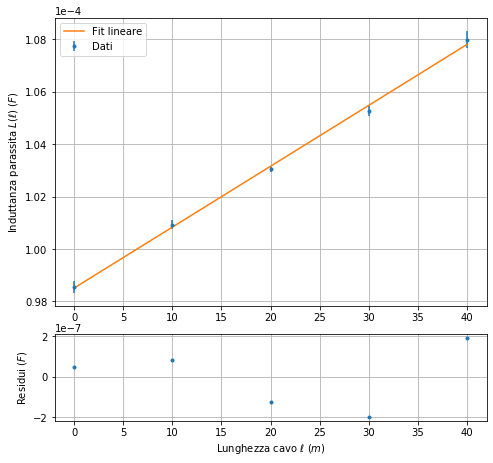

In [10]:
fig4 = plt.figure()
ax4_1 = fig4.add_axes([0,.4,1,1], label='plots')
ax4_2 = fig4.add_axes([0,0,1,.3], label='residuals')
ax4_1.grid()
ax4_1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4_1.errorbar(tau2df['length'], tau2df['inductance'], yerr=tau2df['inductanceerr'], ls='None', marker='.', label='Dati')
ax4_1.plot(tau2df['length'], linf(tau2df['length'], *popt4), label='Fit lineare')
ax4_1.set_ylabel('Induttanza parassita $L(\ell)$ ($F$)')
ax4_1.legend(loc='best')
ax4_2.grid()
ax4_2.plot(tau2df['length'], tau2df['inductance'] - linf(tau2df['length'], *popt4), '.')
ax4_2.set_xlabel('Lunghezza cavo $\ell$ ($m$)')
ax4_2.set_ylabel('Residui ($F$)')
display(*popt4, np.sqrt(np.diag(pcov4)))

In [11]:
chiq2 = chiq(linf(tau2df['length'], *popt4), tau2df['inductance'], tau2df['inductanceerr'])
testchiq(4, .005, .995, chiq2)

Chi quadrato per modello e osservazioni: 2.767404.
Studiamo se il chi quadro è nel range [0.206989, 14.860259]
Test del chi quadro superato!


In [12]:
#pp = PdfPages('multipage.pdf')
#pp.savefig(fig1)
#pp.savefig(fig2)
#pp.savefig(fig3)
#pp.savefig(fig4)
print(tau2df.to_latex())
#pp.close()
fig1.savefig('fig1.pdf', bbox_inches='tight')
fig2.savefig('fig2.pdf', bbox_inches='tight')
fig3.savefig('fig3.pdf', bbox_inches='tight')
fig4.savefig('fig4.pdf', bbox_inches='tight')

\begin{tabular}{lrrrrr}
\toprule
{} &  length &          mean &           std &    inductance &  inductanceerr \\
\midrule
0 &       0 & 1.0147276E-06 & 2.2767907E-09 & 9.8560493E-05 &  2.2189407E-07 \\
1 &      10 & 1.0390011E-06 & 1.7673617E-09 & 1.0091818E-04 &  1.7267471E-07 \\
2 &      20 & 1.0607829E-06 & 1.0478787E-09 & 1.0303384E-04 &  1.0354753E-07 \\
3 &      30 & 1.0839236E-06 & 2.3376399E-09 & 1.0528150E-04 &  2.2788767E-07 \\
4 &      40 & 1.1118193E-06 & 3.4562786E-09 & 1.0799101E-04 &  3.3630146E-07 \\
\bottomrule
\end{tabular}

